In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn


In [12]:
data = pd.read_csv('AMZN.csv')

In [13]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [14]:
data = data[['Date', 'Close']]

In [15]:
data['Date'] = pd.to_datetime(data['Date'])

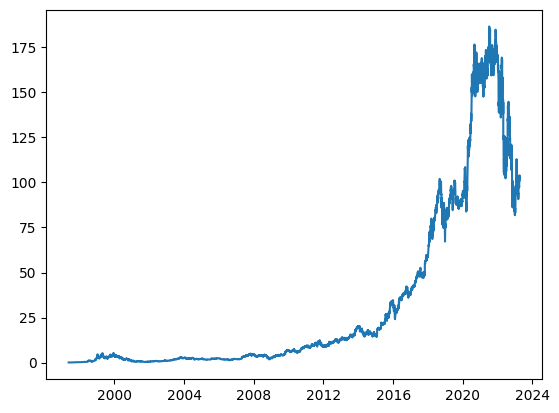

In [16]:
plt.plot(data['Date'],data['Close'])

In [17]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [19]:
from copy import deepcopy as dc
def prepare_data_for_lstm(data, lookback):
    df = dc(data)
    df.set_index('Date', inplace=True)
    for i in range(1, lookback+1):
        df[f'lag_{i}'] = df['Close'].shift(i)
    df.dropna(inplace=True)
    return df
shifted_data = prepare_data_for_lstm(data, 7)
shifted_data.head()


,Close,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354


In [24]:
shifted_data_Array= shifted_data.to_numpy()

In [25]:
shifted_data_Array

array([[7.91670000e-02, 7.50000000e-02, 6.97920000e-02, ...,
        8.54170000e-02, 8.64580000e-02, 9.79170000e-02],
       [7.65630000e-02, 7.91670000e-02, 7.50000000e-02, ...,
        8.17710000e-02, 8.54170000e-02, 8.64580000e-02],
       [7.52600000e-02, 7.65630000e-02, 7.91670000e-02, ...,
        7.13540000e-02, 8.17710000e-02, 8.54170000e-02],
       ...,
       [1.02410004e+02, 1.03290001e+02, 1.02000000e+02, ...,
        9.80400010e+01, 9.81299970e+01, 9.87099990e+01],
       [1.03949997e+02, 1.02410004e+02, 1.03290001e+02, ...,
        9.72399980e+01, 9.80400010e+01, 9.81299970e+01],
       [1.01099998e+02, 1.03949997e+02, 1.02410004e+02, ...,
        1.00250000e+02, 9.72399980e+01, 9.80400010e+01]])

In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_data_Array = scaler.fit_transform(shifted_data_Array)

In [28]:
shifted_data_Array

array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.08342464,  0.11398769,  0.09747802, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

In [30]:
X = shifted_data_Array[:, 1:]
Y = shifted_data_Array[:, 0]
X.shape, Y.shape

((6509, 7), (6509,))

In [31]:
X = np.flip(X, axis=1)
X

array([[-0.99969839, -0.99982128, -0.99983244, ..., -0.99998325,
        -1.        , -0.99995531],
       [-0.99982128, -0.99983244, -0.99987154, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.99983244, -0.99987154, -0.99998325, ..., -0.99994415,
        -0.99989946, -0.99993855],
       ...,
       [ 0.05779984,  0.05158   ,  0.0506149 , ...,  0.07431453,
         0.09308121,  0.10690997],
       [ 0.05158   ,  0.0506149 ,  0.04203581, ...,  0.09308121,
         0.10691495,  0.09747299],
       [ 0.0506149 ,  0.04203581,  0.07431453, ...,  0.10691495,
         0.09747802,  0.11398769]])

In [86]:
split_index = int(len(X) * 0.95)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = Y[:split_index], Y[split_index:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 7), (326, 7), (6183,), (326,))

In [87]:
lookback = 7
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback,1))
y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

In [88]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((6183, 7, 1), (326, 7, 1), (6183, 1), (326, 1))

In [89]:
# Make copies of the arrays using array.copy()
X_train_copy = X_train.copy()
y_train_copy = y_train.copy()
X_test_copy = X_test.copy()
y_test_copy = y_test.copy()
# Convert the copied arrays to tensors
X_train_tensor = torch.tensor(X_train_copy).float()
y_train_tensor = torch.tensor(y_train_copy).float()
X_test_tensor = torch.tensor(X_test_copy).float()
y_test_tensor = torch.tensor(y_test_copy).float()

In [90]:
X_train_tensor.shape, X_test_tensor.shape, y_train_tensor.shape, y_test_tensor.shape

(torch.Size([6183, 7, 1]),
 torch.Size([326, 7, 1]),
 torch.Size([6183, 1]),
 torch.Size([326, 1]))

In [91]:
from torch.utils.data import Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train_tensor, y_train_tensor)
test_dataset = TimeSeriesDataset(X_test_tensor, y_test_tensor)

In [92]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader (test_dataset, batch_size = batch_size, shuffle = False)

In [93]:
for _,batch in enumerate(train_loader):
    print("batch[0] =", batch[0])
    print("batch[1] =", batch[1])
    X_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(X_batch.shape, y_batch.shape)
    break

batch[0] = tensor([[[-0.9917],
         [-0.9921],
         [-0.9927],
         [-0.9929],
         [-0.9929],
         [-0.9936],
         [-0.9935]],

        [[-0.9611],
         [-0.9591],
         [-0.9591],
         [-0.9601],
         [-0.9611],
         [-0.9610],
         [-0.9591]],

        [[-0.9904],
         [-0.9899],
         [-0.9897],
         [-0.9891],
         [-0.9894],
         [-0.9898],
         [-0.9901]],

        [[ 0.7273],
         [ 0.7528],
         [ 0.7324],
         [ 0.7321],
         [ 0.7406],
         [ 0.7167],
         [ 0.7392]],

        [[-0.9312],
         [-0.9323],
         [-0.9322],
         [-0.9329],
         [-0.9340],
         [-0.9327],
         [-0.9338]],

        [[ 0.0096],
         [ 0.0093],
         [ 0.0469],
         [ 0.0228],
         [ 0.0587],
         [ 0.0309],
         [ 0.0186]],

        [[ 0.9710],
         [ 0.9733],
         [ 0.9463],
         [ 0.9154],
         [ 0.9025],
         [ 0.9152],
         [ 0.9216

In [94]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self,x):
        batch_sizes = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_sizes, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_sizes, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0,c0))
        out = self.fc(out[: , -1, :])
        return out
model = LSTM(1, 4, 1)
model.to(device)
model
    

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [95]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    for batch_index, batch in enumerate(train_loader):
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)
        output = model(X_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index%100 == 99:
            avg_loss_across_batches = running_loss/100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1, avg_loss_across_batches))
            running_loss = 0.0
    print()

In [96]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    for batch_index, batch in enumerate(test_loader):
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)
        with torch.no_grad():
            output = model(X_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
    avg_loss_across_batch = running_loss/len(test_loader)
    print('Validation Loss: {0: .3f}'.format(avg_loss_across_batch))
    print()

In [97]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.391
Batch 200, Loss: 0.112
Batch 300, Loss: 0.085

Validation Loss:  0.269

Epoch: 2
Batch 100, Loss: 0.043
Batch 200, Loss: 0.021
Batch 300, Loss: 0.013

Validation Loss:  0.023

Epoch: 3
Batch 100, Loss: 0.006
Batch 200, Loss: 0.004
Batch 300, Loss: 0.003

Validation Loss:  0.008

Epoch: 4
Batch 100, Loss: 0.002
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Validation Loss:  0.005

Epoch: 5
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Validation Loss:  0.005

Epoch: 6
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Validation Loss:  0.005

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Validation Loss:  0.005

Epoch: 8
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Validation Loss:  0.004

Epoch: 9
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Validation Loss:  0.005

Epoch: 10
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 30

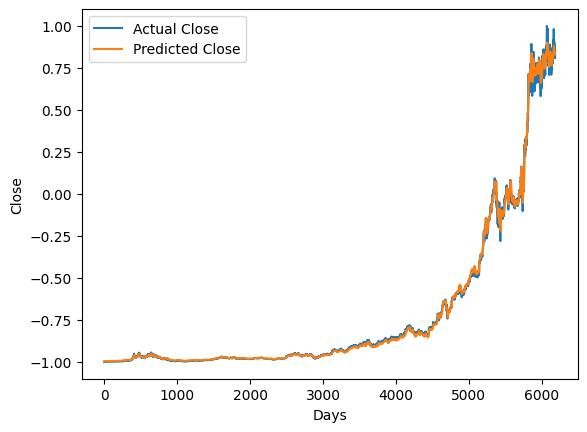

In [98]:
with torch.no_grad():
    predicted = model(X_train_tensor.to(device)).to('cpu').numpy()
plt.plot(y_train_tensor, label = "Actual Close")
plt.plot(predicted, label = "Predicted Close")
plt.xlabel("Days")
plt.ylabel("Close")
plt.legend()
plt.show()

In [99]:
train_predictions = predicted.flatten()
dummmies = np.zeros((X_train_tensor.shape[0], lookback+1))
dummmies[:, 0] = train_predictions
dummmies = scaler.inverse_transform(dummmies)
train_predictions = dc(dummmies[:, 0])
train_predictions

array([  0.48227862,   0.48107251,   0.47999979, ..., 171.56698748,
       171.01881759, 170.77549408])

In [100]:
dummies = np.zeros((X_train_tensor.shape[0], lookback+1))
dummies[:, 0] = y_train_tensor.flatten()
dummies = scaler.inverse_transform(dummies)
new_y_train = dc(dummies[:, 0])
new_y_train

array([7.91646265e-02, 7.65634249e-02, 7.52572660e-02, ...,
       1.69091505e+02, 1.73315001e+02, 1.68871003e+02])

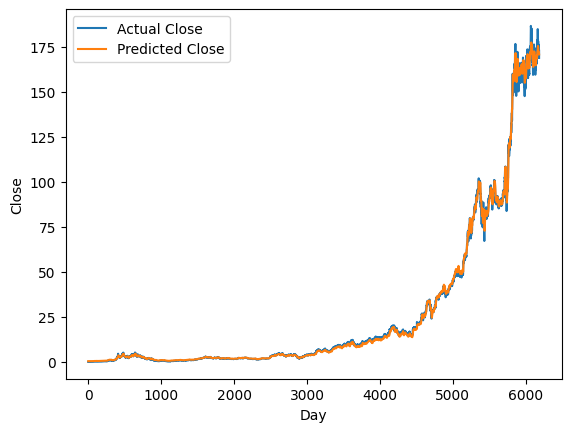

In [101]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [102]:
test_predictions = model(X_test_tensor.to(device)).detach().cpu().numpy().flatten()
dummies = np.zeros((X_test_tensor.shape[0], lookback + 1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([170.58806861, 170.06966247, 169.66834375, 169.35200874,
       169.57377785, 169.78783228, 169.77983414, 169.82150895,
       169.82678361, 169.68327843, 169.28305466, 169.04627862,
       169.02723649, 168.47136304, 167.62127035, 166.81634852,
       166.01531738, 165.68654884, 165.74264142, 165.50048511,
       165.11108301, 164.61733271, 163.60649909, 162.01073972,
       158.93474102, 155.73011622, 152.72330503, 149.60968894,
       147.288928  , 146.4245287 , 147.39502145, 149.45600684,
       151.20573734, 150.96283068, 152.29408453, 155.04997982,
       157.46914733, 159.53640784, 160.83596927, 160.97685658,
       160.93326977, 160.52395292, 160.47516371, 160.11774305,
       159.28855446, 158.21626468, 156.53210336, 155.41295305,
       155.45363295, 155.72724823, 155.83104062, 155.9131341 ,
       155.58762262, 154.6918366 , 152.17960943, 148.90882074,
       146.6090695 , 146.43113175, 146.95908674, 147.05051787,
       147.84289501, 150.16829143, 153.13899706, 156.22

In [103]:
dummies = np.zeros((X_test_tensor.shape[0], lookback+1))
dummies[:, 0] = y_test_tensor.flatten()
dummies = scaler.inverse_transform(dummies)

new_test_y = dummies[:, 0]
new_test_y

array([170.01749949, 167.07899763, 170.41700626, 171.03700377,
       171.0684961 , 169.66949429, 170.66099675, 169.20100565,
       168.64449858, 166.71699707, 170.40449492, 167.52200227,
       164.35699578, 163.25399737, 162.55400179, 161.48599177,
       165.36199892, 165.20699954, 161.21400501, 162.13799851,
       158.91749416, 156.29899568, 151.66749509, 142.64300408,
       144.54400445, 139.98599336, 138.87249844, 139.63749627,
       143.97799855, 149.57350001, 151.19349835, 150.61250219,
       138.84550541, 157.63949825, 157.93550165, 161.41349717,
       161.18949925, 159.003495  , 153.29350176, 155.1670061 ,
       156.51049894, 158.10049453, 154.6524962 , 152.60149876,
       150.19749381, 144.82699629, 151.35800212, 153.78849709,
       153.56300403, 151.14199678, 152.05250627, 147.89849848,
       145.64100565, 137.45300383, 136.01449488, 139.27900567,
       146.81750468, 145.52450739, 141.8529947 , 147.36650272,
       153.10400311, 157.23899657, 161.25050521, 161.49

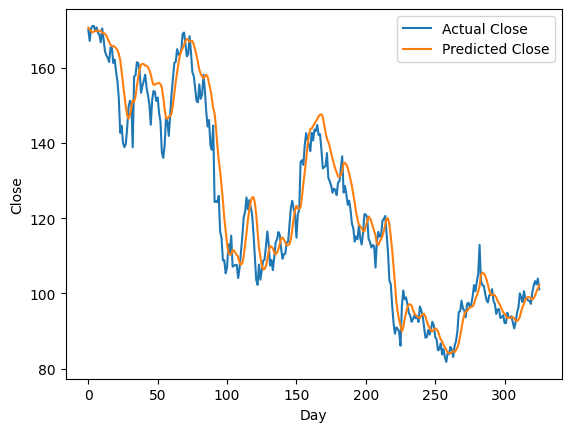

In [104]:
plt.plot(new_test_y, label = "Actual Close")
plt.plot(test_predictions, label = "Predicted Close")
plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()